<a href="https://colab.research.google.com/github/mkosaka1/ASD_Traits_Predicting_Age/blob/master/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [150]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [151]:
ls

drive/  sample_data/


In [152]:
# IMPORT NECESSARY LIBRARIES
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
from IPython.display import Audio
import os # interface with underlying OS that python is running on
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
import keras
from keras.optimizers import SGD
from sklearn.metrics import classification_report
from keras.models import Sequential, Model, model_from_json
from keras.layers import Conv1D, MaxPooling2D, AveragePooling1D
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Dense, Embedding, LSTM
from keras.regularizers import l2
from keras.constraints import max_norm
from keras.callbacks import EarlyStopping, ModelCheckpoint
import seaborn as sns
from keras.utils import to_categorical
from glob import glob
import cv2
from sklearn.utils import shuffle




In [153]:
def get_images(directory):
    Images = []
    Labels = []  # 0 for Building , 1 for forest, 2 for glacier, 3 for mountain, 4 for Sea , 5 for Street
    label = 0
    
    for labels in os.listdir(directory): #Main Directory where each class label is present as folder name.
        if labels == 'angry': #Folder contain Glacier Images get the '2' class label.
            label = 'angry'
        elif labels == 'calm':
            label = 'calm'
        elif labels == 'disgust':
            label = 'disgust'
        elif labels == 'fearful':
            label = 'fearful'
        elif labels == 'happy':
            label = 'happy'
        elif labels == 'neutral':
            label = 'neutral'
        elif labels == 'sad':
            label = 'sad'
        elif labels == 'surprised':
            label = 'surprised'
        
        for image_file in os.listdir(directory+labels): #Extracting the file name of the image from Class Label folder
            image = cv2.imread(directory+labels+r'/'+image_file) #Reading the image (OpenCV)
            image = cv2.resize(image,(224,224)) #Resize the image, Some images are different sizes. (Resizing is very Important)
            image= cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            Images.append(image)
            Labels.append(label)
    
    return shuffle(Images,Labels,random_state=200) #Shuffle the dataset you just prepared.

def get_classlabel(class_code):
    labels = {'angry':'angry', 'calm':'calm', 'disgust':'disgust', 'fearful':'fearful', 'happy':'happy', 'neutral':'neutral','sad':'sad','surprised':'surprised'}
    
    return labels[class_code]


In [154]:
Images, Labels = get_images('/content/drive/My Drive/sorted_data/') #Extract the training images from the folders.

# Images = np.array(Images) #converting the list of images to numpy array.
# Labels = np.array(Labels)

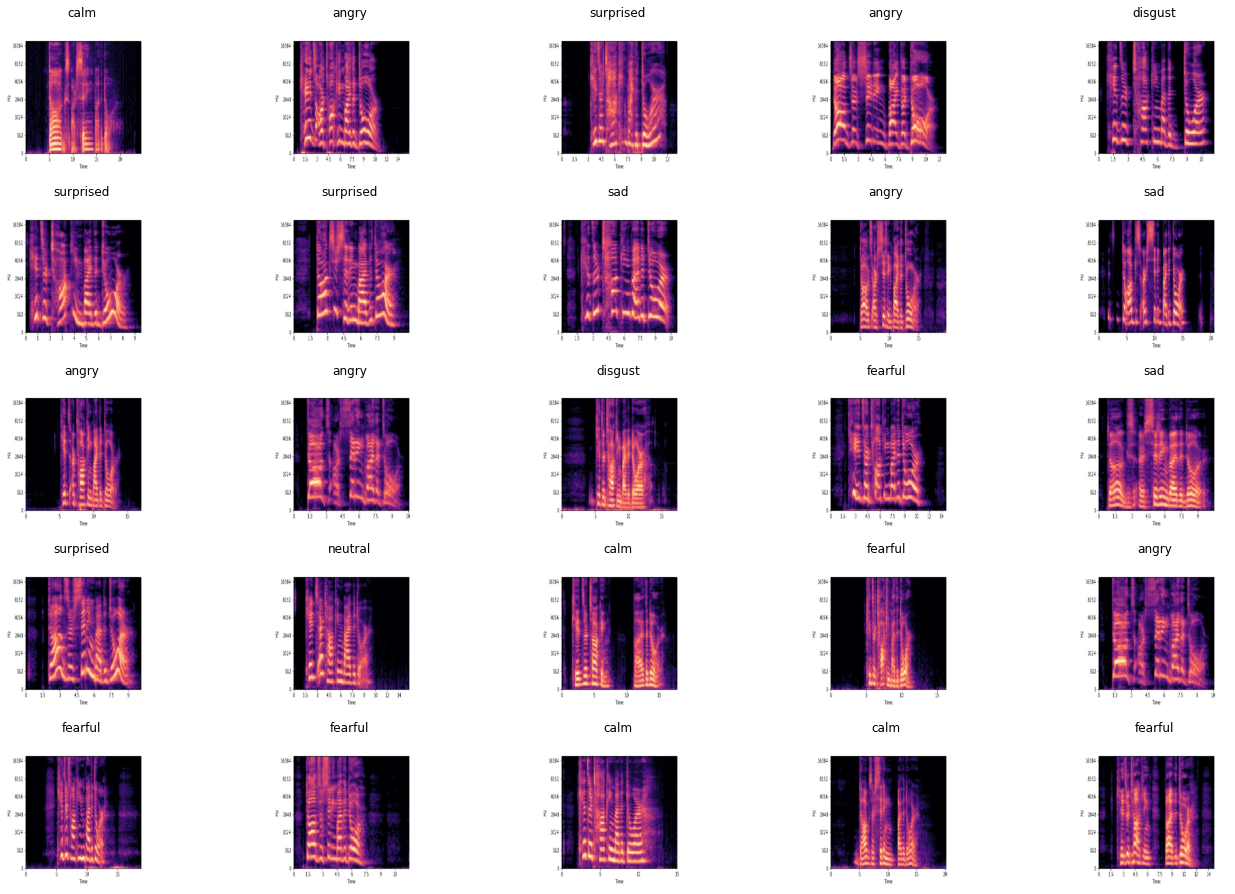

In [155]:
from random import randint

f,ax = plt.subplots(5,5) 
f.subplots_adjust(0,0,3,3)
for i in range(0,5,1):
    for j in range(0,5,1):
        rnd_number = randint(0,len(Images))
        ax[i,j].imshow(Images[rnd_number])
        ax[i,j].set_title(get_classlabel(Labels[rnd_number]))
        ax[i,j].axis('off')

In [156]:
from sklearn.model_selection import train_test_split
X_model, X_test, y_model, y_test = train_test_split(Images, Labels, test_size=0.2,random_state=42, stratify=Labels)
X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, test_size=0.2,random_state=42,stratify=y_model)


In [157]:
# Images = np.array(Images) #converting the list of images to numpy array.
# Labels = np.array(Labels)

In [158]:
from keras.utils import np_utils, to_categorical

lb = LabelEncoder()

X_train=np.array(X_train)/255
# y_train = to_categorical(lb.fit_transform(y_train),num_classes=8)

X_test=np.array(X_test)/255
# y_test = to_categorical(lb.fit_transform(y_test),num_classes=8)

X_val=np.array(X_val)/255
# y_val = to_categorical(lb.fit_transform(y_val),num_classes=8)



y_val=np_utils.to_categorical(lb.fit_transform(y_val))
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [159]:
X_test.shape

(288, 224, 224, 3)

In [160]:
X_train.shape

(921, 224, 224, 3)

In [161]:
y_test.shape

(288, 8)

In [162]:
X_train[90][50]

array([[1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        ],
       [1.

In [163]:
y_test

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [164]:
print(lb.classes_)

['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']


In [16]:
# from keras.preprocessing.image import ImageDataGenerator

# datagen = ImageDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by std of the dataset
#         samplewise_std_normalization=False,  # divide each input by its std
#         zca_whitening=False,  # apply ZCA whitening
#         rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
#         width_shift_range=0.3,  # randomly shift images horizontally (fraction of total width)
#         height_shift_range=0.3,  # randomly shift images vertically (fraction of total height)
#         horizontal_flip=True,  # randomly flip images
#         vertical_flip=True)  # randomly flip images

In [165]:
from keras.applications import vgg16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
# setting image size
img_rows, img_cols = 224, 224
input_shape= (224,224,3)
model = vgg16.VGG16(weights= 'imagenet', include_top=False, input_shape= input_shape,pooling='avg')

In [329]:
from keras import applications

model = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (224, 224, 3),pooling='avg')

In [330]:
# freezing the layers 
for layer in model.layers[:17]:
    layer.trainable = False


#Adding custom Layers 

x = model.output
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(4096, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dropout(0.2)(x)
x = Dense(4096, activation="relu")(x)
x = Dropout(0.4)(x)

In [331]:
predictions = Dense(8, activation="softmax")(x)

# creating the final model 
model_final = Model(inputs = model.input, outputs = predictions)

# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics=["accuracy"])

In [332]:
model_final.summary()

Model: "functional_103"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_56 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)    

In [333]:
history = model_final.fit(X_train,y_train, batch_size=16,epochs= 20, validation_data= (X_val,y_val))


Epoch 1/20
58/58 [==============================] - 3s 52ms/step - loss: 2.0927 - accuracy: 0.1650 - val_loss: 1.9151 - val_accuracy: 0.2338
Epoch 2/20
58/58 [==============================] - 3s 47ms/step - loss: 1.8810 - accuracy: 0.2486 - val_loss: 1.7358 - val_accuracy: 0.3377
Epoch 3/20
58/58 [==============================] - 3s 47ms/step - loss: 1.7426 - accuracy: 0.3268 - val_loss: 1.7491 - val_accuracy: 0.3160
Epoch 4/20
58/58 [==============================] - 3s 48ms/step - loss: 1.5772 - accuracy: 0.3844 - val_loss: 1.5598 - val_accuracy: 0.3810
Epoch 5/20
58/58 [==============================] - 3s 47ms/step - loss: 1.4772 - accuracy: 0.4343 - val_loss: 1.4247 - val_accuracy: 0.4502
Epoch 6/20
58/58 [==============================] - 3s 48ms/step - loss: 1.3492 - accuracy: 0.5027 - val_loss: 1.7512 - val_accuracy: 0.3810
Epoch 7/20
58/58 [==============================] - 3s 48ms/step - loss: 1.2259 - accuracy: 0.5440 - val_loss: 1.4768 - val_accuracy: 0.4632
Epoch 8/20
58

# Inception

In [40]:
from keras.applications import inception_v3
from keras.layers import Dense,GlobalAveragePooling2D, GlobalAveragePooling1D
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D


imagenet=inception_v3.InceptionV3(weights='imagenet',include_top=False, input_shape=(277,277,3))
imagenet_new=imagenet.output
new_model = Sequential()
new_model.add(imagenet)
new_model.add(Flatten())
new_model.add(Dense(1024,activation='relu')) #dense layer 2
new_model.add(Dropout(0.2))
new_model.add(Dense(512,activation='relu')) #dense layer 3
new_model.add(Dropout(0.2))
new_model.add(Dense(256,activation='relu')) #dense layer 3
new_model.add(Dense(8,activation='softmax')) #final layer with softmax activation
new_model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# new_model.load_weights('/content/new_model.h5')

In [41]:
for layer in new_model.layers[:1]:
    layer.trainable=False

In [42]:
new_model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

# step_size_train=train_generator.n//train_generator.batch_size
history = new_model.fit(X_train,
          y_train,
          epochs=10,
          batch_size=8,
          validation_data=(X_val, y_val))

Epoch 1/10
116/116 [==============================] - 17s 148ms/step - loss: 13.1147 - accuracy: 0.1878 - val_loss: 2.4845 - val_accuracy: 0.2511
Epoch 2/10
116/116 [==============================] - 16s 135ms/step - loss: 2.4544 - accuracy: 0.2486 - val_loss: 2.0115 - val_accuracy: 0.1991
Epoch 3/10
116/116 [==============================] - 16s 135ms/step - loss: 1.9967 - accuracy: 0.2823 - val_loss: 1.8143 - val_accuracy: 0.2641
Epoch 4/10
116/116 [==============================] - 16s 136ms/step - loss: 1.8677 - accuracy: 0.3366 - val_loss: 1.9058 - val_accuracy: 0.1905
Epoch 5/10
116/116 [==============================] - 16s 135ms/step - loss: 1.7993 - accuracy: 0.3301 - val_loss: 1.7307 - val_accuracy: 0.3550
Epoch 6/10
116/116 [==============================] - 16s 135ms/step - loss: 1.6998 - accuracy: 0.3659 - val_loss: 1.7677 - val_accuracy: 0.3247
Epoch 7/10
116/116 [==============================] - 16s 135ms/step - loss: 1.7553 - accuracy: 0.3170 - val_loss: 1.7912 - val_a